# Direct DPC++ Programming next steps

##### Sections
- _Code_: [Device selector](#Device-selector)
- _Code_: [Data dependencies](#Data-dependencies)
- _Code_: [Unified Shared Memory](#Unified-Shared-Memory)
- _Code_: [Monte carlo Pi](#Monte-carlo-Pi)

In this session, let's explore data parallel programming with DPC++ in more detail.

# Device selector

For the next example let's practice the device selector concept. We perform the same vector add example that has been introduced previously but explicitly select a device like a GPU where we want to execute our enqueued work items.

Inspect the code below - there are no modifications necessary. Run the first cell to create the single source cpp file, next create a script to compile and execute our example. Then run the cell below it to compile and execute the code.
1. Inspect the code cell below, then click run ▶ to save the code to a file
2. Run ▶ the cell in the __Build and Run__ section below the code snippet to compile and execute the code in the saved file

In [ ]:
%%writefile lab/vector-add-select.cpp
//==============================================================
// Copyright (c) 2020 Intel Corporation
//
// SPDX-License-Identifier: Apache-2.0
// =============================================================

#include <CL/sycl.hpp>
#define SIZE 1024

using namespace cl::sycl;

int main() {
  // Initialize container.
  std::array<int, SIZE> a, b, c;
  for (int i = 0; i<SIZE; ++i) {
    a[i] = i + 1;
    b[i] = -i;
    c[i] = 0;
  }
  {
    std::cout << "\nAvailable devices:\n";
    // Report available devices.
    auto platforms = platform::get_platforms();
    for (auto &platform : platforms) {
      std::cout << "Platform: "
        << platform.get_info<info::platform::name>() << std::endl;
      auto devices = platform.get_devices();
      for (auto &device : devices ) {
        std::cout << " Device: "
          << device.get_info<info::device::name>()
          << std::endl;
      }
    }
    
    range<1> r{SIZE};
    gpu_selector selector;
      
    queue q(selector);
    
    // Print out the device information.
    std::cout << "\nRunning on device: "
              << q.get_device().get_info<info::device::name>() << "\n";
      
    buffer<int, 1> a_buf(a.data(), r);
    buffer<int, 1> b_buf(b.data(), r);
    buffer<int, 1> c_buf(c.data(), r);
    q.submit([&](auto &h) {
      accessor a(a_buf, h, read_only);
      accessor b(b_buf, h, read_only);
      accessor c(c_buf, h, write_only);
      h.parallel_for(r,[=](id<1> idx) {
        c[idx] = a[idx] + b[idx];
      });
    }).wait();
  }
  std::cout << "DONE.\n";
  return 0;
}

In [ ]:
%%writefile scripts/run_vector_add_select.sh
#!/bin/bash
#==========================================
# Copyright (c) 2020 Intel Corporation
#
# SPDX-License-Identifier: Apache-2.0
#==========================================

source /opt/intel/inteloneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling DPC++ example
rm -rf bin/vector-add
dpcpp lab/vector-add-select.cpp -o bin/vector-add -tbb
bin/vector-add

Select the cell below and click Run ▶ to compile and execute the code above:

In [ ]:
! chmod 755 q; chmod 755 scripts/run_vector_add_select.sh; if [ -x "$(command -v qsub)" ]; then ./q scripts/run_vector_add_select.sh; else ./scripts/run_vector_add_select.sh; fi

# Data dependencies

Let's have a deeper look at buffers and their data access patterns.

What was a SYCL buffer again? An Object which encapsulates data that is shared between host and device. Accessors are objects that grant access to data stored in buffers. Along with an accessor you can specify a so called access mode, which allows explicitly restricting to read or write only access. This means you need an accessor to access data that is encapsulated by a buffer.

That being said, the SYCL Buffer concept encodes implicit dependencies through accessors. Work submitted to queues can be executed asynchronously by default. Which means submitted work can be executed in an arbitrary order when all data dependencies are fulfilled. And accessors to buffers express data dependencies. 

Our next example demonstrates expressing a simple data flow graph by using the SYCL buffer & accessor concept.

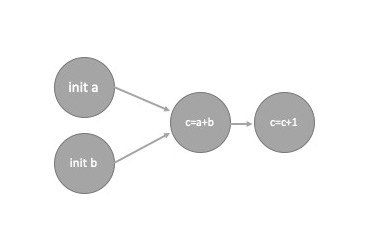

We'll use the same numbers like in the previous example. Initial values: ``A[i] = i, B[i] = -i``
Modify the following code example by implementing the data flow graph as shown above.

In [ ]:
%%writefile lab/data-flow.cpp
//==============================================================
// Copyright (c) 2020 Intel Corporation
//
// SPDX-License-Identifier: Apache-2.0
// =============================================================

#include <CL/sycl.hpp>
#define SIZE 1024

using namespace sycl;

int main() {
    
    std::array<int, SIZE> c;
    std::array<int, SIZE> c_res;
    std::fill_n(c_res.begin(), SIZE, 1);
    
    {
        range<1> r{SIZE};
        buffer<int, 1> a_buf{r};
        // 1. Create more buffer objects to hold the data
        
        // 2. Using a GPU device selector
        queue q;
        q.submit([&](auto& h) {
            accessor a(a_buf, h, write_only);
            h.parallel_for(r, [=](auto idx) {
                a[idx] = idx; }); 
        });
        
        // 3. Adding more work to the queue to create our data graph
        
    }
    
    if (std::equal(c.begin(), c.end(), c_res.begin())) {
        std::cout << "DONE.\n";
    } else {
        std::cout << "ERROR. Mismatch in resulting data!\n";
    }
        
    return 0;
}

### Solution: (Don't peak until you have to)

In [ ]:
%%writefile lab/data-flow.cpp
//==============================================================
// Copyright (c) 2020 Intel Corporation
//
// SPDX-License-Identifier: Apache-2.0
// =============================================================

#include <CL/sycl.hpp>
#define SIZE 1024

using namespace sycl;

int main() {
    
    std::array<int, SIZE> c;
    // Reference vector for sanity check
    std::array<int, SIZE> c_res;
    std::fill_n(c_res.begin(), SIZE, 1);
    
    {
        range<1> r{SIZE};
        queue q(gpu_selector{});
        buffer<int, 1> a_buf{r};
        buffer<int, 1> b_buf{r};
        buffer<int, 1> c_buf{c.data(), r};
    
    // Create a simple data dependency graph,
    // Following structure:
    // (1) ----> (3) ---> (4)
    // (2) __/   
    
        q.submit([&](auto& h) {
            accessor a(a_buf, h, write_only);
            h.parallel_for(r, [=](auto idx) {
                a[idx] = idx; }); 
        });
        q.submit([&](auto& h) {
            accessor b(b_buf, h, write_only);
            h.parallel_for(r, [=](auto idx) {
                b[idx] = -idx; }); 
        });
        q.submit([&](auto& h) {
            accessor a(a_buf, h, read_only);
            accessor b(b_buf, h, read_only);
            accessor c(c_buf, h, write_only);
            h.parallel_for(r, [=](auto idx) {
                c[idx] = a[idx] + b[idx]; }); 
        });
        q.submit([&](auto& h) {
            accessor c(c_buf, h, read_write);
            h.parallel_for(r, [=](auto idx) {
                c[idx] += 1; }); 
        }).wait();
    }
    
    if (std::equal(c.begin(), c.end(), c_res.begin())) {
        std::cout << "DONE.\n";
    } else {
        std::cout << "ERROR. Mismatch in resulting data!\n";
    }
    
    return 0;
}

Select the cell below and click Run ▶ to compile and execute the code above:

In [ ]:
%%writefile scripts/run_data_flow.sh
#!/bin/bash
#==========================================
# Copyright (c) 2020 Intel Corporation
#
# SPDX-License-Identifier: Apache-2.0
#==========================================

source /opt/intel/inteloneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling DPC++ example
rm -rf bin/data-flow
dpcpp lab/data-flow.cpp -o bin/data-flow -tbb
bin/data-flow

In [ ]:
! chmod 755 q; chmod 755 scripts/run_data_flow.sh; if [ -x "$(command -v qsub)" ]; then ./q scripts/run_data_flow.sh; else ./run_data_flow.sh; fi

# Unified Shared Memory

Let's give the concept of Unified Shared Memory a try with our next exercise.

To explore implicit and explict data movement with USM we use a combination instead of buffers for our simple example:

Implicit data movement with USM shared memory will be used to copy the initialized vectors a and b onto the device.
To copy the resulting vector c back to the host we use explict USM device memory. That is by definition accessible on the device only.

We'll use the same numbers like in the previous examples. Initial values: ``A[i] = i + 1, B[i] = -i``

In [ ]:
%%writefile lab/usm.cpp
//==============================================================
// Copyright (c) 2020 Intel Corporation
//
// SPDX-License-Identifier: Apache-2.0
// =============================================================

#include <CL/sycl.hpp>

#define N 1024

using namespace sycl;

int main() {
    
    std::vector<int> c_host(N);
    std::vector<int> c_res(N);
    std::fill_n(c_res.begin(), N, 1);
    
    {
        queue q(gpu_selector{});
    
        // 1. Allocate Shared USM for vector A & B ( for implicit copying ).
        /* ... */
        int *c_dev = malloc_device<int>(N, q);
    
        // 2. Modify kernel for vector add.
        auto e1 = q.parallel_for(range<1>(N), [=](id<1> i) { c_dev[i] = i; });
    
        // 3. Copy data back to host.
 
        free(c_dev,q);
    }
    
    if (std::equal(c_host.begin(), c_host.end(), c_res.begin())) {
        std::cout << "DONE.\n";
    } else {
        std::cout << "ERROR. Mismatch in resulting data!\n";
    }    
        
    return 0;
}

### Solution: (Don't peak until you have to)

In [ ]:
%%writefile lab/usm.cpp
//==============================================================
// Copyright (c) 2020 Intel Corporation
//
// SPDX-License-Identifier: Apache-2.0
// =============================================================

#include <CL/sycl.hpp>

#define N 1024

using namespace sycl;

int main() {
    
    std::vector<int> c_host(N);
    std::vector<int> c_res(N);
    std::fill_n(c_res.begin(), N, 1);
    
    {
        queue q(gpu_selector{});
        
        int *a = malloc_shared<int>(N, q);
        int *b = malloc_shared<int>(N, q);
        int *c_dev = malloc_device<int>(N, q);
        
        for (int i = 0; i < N; ++i) {
            a[i] = i + 1;
            b[i] = -i;
        }
        
        auto e1 = q.parallel_for(range<1>(N), [=](id<1> i) { c_dev[i] = a[i] + b[i]; });
                 
        q.submit([&](auto &h) {
              h.depends_on(e1);
              h.memcpy(c_host.data(), c_dev, sizeof(int) * N);
        }).wait();
                 
        free(a,q);
        free(b,q);
        free(c_dev,q);
    }

    if (std::equal(c_host.begin(), c_host.end(), c_res.begin())) {
        std::cout << "DONE.\n";
    } else {
        std::cout << "ERROR. Mismatch in resulting data!\n";
    }
    
    return 0;
}

Select the cell below and click Run ▶ to compile and execute the code above:

In [ ]:
%%writefile scripts/usm.sh
#!/bin/bash
#==========================================
# Copyright (c) 2020 Intel Corporation
#
# SPDX-License-Identifier: Apache-2.0
#==========================================

source /opt/intel/inteloneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling DPC++ example
rm -rf bin/usm
dpcpp lab/usm.cpp -o bin/usm -tbb
bin/usm

In [ ]:
! chmod 755 q; chmod 755 scripts/usm.sh; if [ -x "$(command -v qsub)" ]; then ./q scripts/usm.sh; else ./usm.sh; fi

# Monte carlo Pi

Monte Carlo Simulation is a broad category of computation which utilizes statistical analysis to reach a result. This sample utilizes the Monte Carlo Procedure to estimate the value of pi: By inscribing a circle of radius 1 inside a 2x2 square, and then sampling a large number of random coordinates falling uniformly within the square, the value of pi can be estimated using the ratio of samples which fall inside the circle divided by the total number of samples.

This method of estimation works for calculating pi because the expected value of the sample ratio is equal to the ratio of a circle's area divided by the square's: a circle of radius 1 has an area of pi units squared, while a 2x2 square has an area of 4 units squared, yielding a ratio of pi/4. Therefore, to estimate the value of pi, our solution will be 4 times the sample ratio.
Some commonly used pattern, like a work group reduction come predefined with DPC++ as a vendor specific extension. SYCL's ND range object is used to partition the execution space.

Random number generation inside kernel code is provided by the DPC++ library (oneDPL). This gives more flexibility to a programmer, by in-flight generating random numbers within a compute kernel. Another option would be using oneMKL's API to generate random numbers in a kind of bulk mode on target device and prefill a buffer. Or to just generate random numbers on the host and copy to target device. Best option depends on your application.

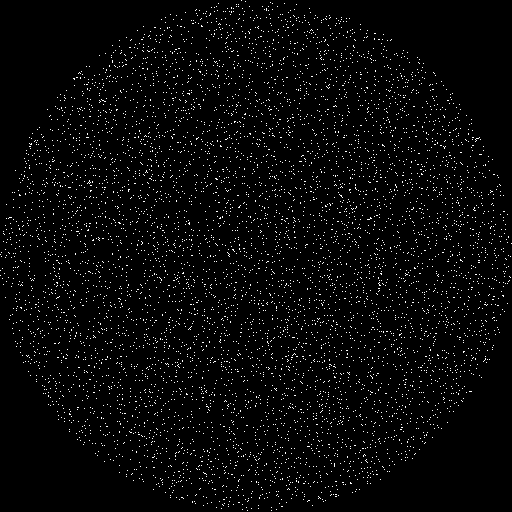

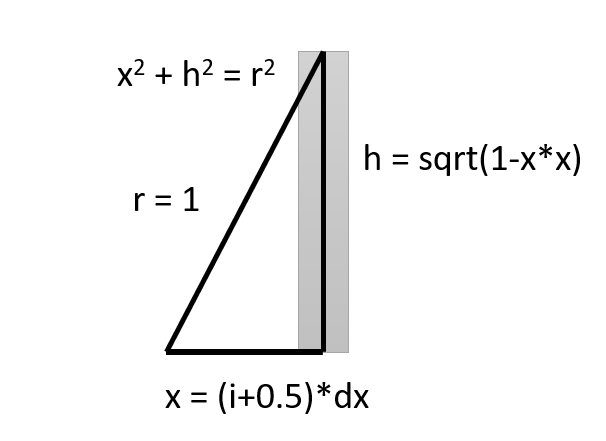

In [ ]:
%%writefile lab/random.cpp
//==============================================================
// Copyright (c) 2020 Intel Corporation
//
// SPDX-License-Identifier: Apache-2.0
// =============================================================

#include <CL/sycl.hpp>
// For random number generation in device code:
#include <oneapi/dpl/random>
// Utility header for output Image
#include "utils.hpp"

using namespace sycl;

const int iter = 10000;
const int img_dimensions = 512;

const int size_wg = 32;
const int num_wg = (int)ceil((double)iter / (double)size_wg);

// Return index of pixel corresponding to a set of simulation coordinates:
int GetPixelIndex(double x, double y) {
    const int radius = img_dimensions / 2;
    int img_x = x * radius + radius;
    int img_y = y * radius + radius;
    return img_y * img_dimensions + img_x;
}

int main() {
    Img<ImgFormat::BMP> image{img_dimensions, img_dimensions};
    int sum = 0;
    
    queue q(default_selector{});
    std::uint32_t seed = 667;
    {
        buffer sum_buf(&sum, range(1));
        buffer<ImgPixel,1> imgplot_buf(image.data(), image.width() * image.height());
        
        q.submit([&](handler& h) {
            accessor img_plot(imgplot_buf, h, read_write);
            accessor sum(sum_buf, h, read_write);
            h.parallel_for(nd_range<1>{num_wg * size_wg, size_wg}, sycl::ONEAPI::reduction(sum, 0, std::plus<int>()), [=](nd_item<1> it, auto& sum) {
                int i = it.get_global_id(0);
                // 1. Step exclude i > iter from result.
                // Get random coords.
                oneapi::std::minstd_rand engine(seed, i);
                oneapi::std::uniform_real_distribution<double> distr(-1.0,1.0);
                // 2. Generate uniformly distributed paiir of coordinates.
                double x = distr(engine);
                double y = static_cast<double>(i)/iter;
                
                // 3. Count and plot if (x,y) is within circle.
                sum+=1;
                img_plot[GetPixelIndex(x,y)].set(255,255,255,255);
            });
        }).wait();
    }

    std::cout << "DONE. \nSum: " << sum << "\n";
    image.write("pi.png");
    return 0;
}


### Solution: (Don't peak until you have to)

In [ ]:
%%writefile lab/random.cpp
//==============================================================
// Copyright (c) 2020 Intel Corporation
//
// SPDX-License-Identifier: Apache-2.0
// =============================================================

#include <CL/sycl.hpp>
// For random number generation in device code:
#include <oneapi/dpl/random>
// Utility header for output Image
#include "utils.hpp"

using namespace sycl;

const int iter = 10000;
const int img_dimensions = 512;

const int size_wg = 32;
const int num_wg = (int)ceil((double)iter / (double)size_wg);

// Return index of pixel corresponding to a set of simulation coordinates:
int GetPixelIndex(double x, double y) {
    const int radius = img_dimensions / 2;
    int img_x = x * radius + radius;
    int img_y = y * radius + radius;
    return img_y * img_dimensions + img_x;
}

int main() {
    Img<ImgFormat::BMP> image{img_dimensions, img_dimensions};
    int sum = 0;
    
    queue q(default_selector{});
    
    std::uint32_t seed = 667;
    {
        buffer sum_buf(&sum, range(1));
        buffer<ImgPixel,1> imgplot_buf(image.data(), image.width() * image.height());

        queue q;
        // Compute a dot-product by reducing all computed values using standard plus functor
        q.submit([&](handler& cgh) {
            accessor img_plot(imgplot_buf, cgh, read_write);
            accessor sum(sum_buf, cgh, read_write);
            cgh.parallel_for<class dot_product>(nd_range<1>{num_wg * size_wg, size_wg}, sycl::ONEAPI::reduction(sum, 0, std::plus<int>()), [=](nd_item<1> it, auto& sum) {
                int i = it.get_global_id(0);
                
                if (i < iter) {
                    // Get random coords
                    oneapi::std::minstd_rand engine(seed, i * 2);
                    oneapi::std::uniform_real_distribution<double> distr(-1.0,1.0);
                    double x = distr(engine);
                    double y = distr(engine);
                    
                    auto hypotenuse_sqr = x * x + y * y;
                    if (hypotenuse_sqr <= 1.0) {
                        sum += 1;
                        img_plot[GetPixelIndex(x,y)].set(255,255,255,255);
                    }
                }
            });
        }).wait();   
    }
    std::cout << "DONE. \nPi: " << 4.0 * (double)sum / iter << "\n";
    image.write("img/pi.png");
    return 0;
}

In [ ]:
%%writefile scripts/run_pi.sh
#!/bin/bash
#==========================================
# Copyright (c) 2020 Intel Corporation
#
# SPDX-License-Identifier: Apache-2.0
#==========================================

source /opt/intel/inteloneapi/setvars.sh > /dev/null 2>&1
/bin/echo "##" $(whoami) is compiling DPC++ example
rm -rf bin/random
dpcpp lab/random.cpp -o bin/random -I ./common
bin/random

Select the cell below and click Run ▶ to compile and execute the code above:

In [ ]:
! chmod 755 q; chmod 755 ./scripts/run_pi.sh; if [ -x "$(command -v qsub)" ]; then ./q scripts/run_pi.sh; else ./scripts/run_pi.sh; fi

### 